In [ ]:
import sys,os
import shutil
os.chdir("/home/shared")
sys.path.append("./src")
sys.path.append("./src/kriging")

# clear RBniCS cache
RBNICS_CACHE = "/home/shared/Subfin_NO_GEOMETRY_PARAM"
if os.path.exists(RBNICS_CACHE):
    shutil.rmtree(RBNICS_CACHE)

from dolfin import *
from rbnics import *

In [ ]:
import time
import numpy as np
import importlib
import inverse_id
importlib.reload(inverse_id)
from inverse_id import sensor_output, plot_sensor, identify_with_error, read_sensor, monitor, control_cooling, reset_cache
from kriging import Kriging

# Define finite element (FE) model
We consider a steady-state heat transfer problem on a thermal fin using an FE method. The thermal fin model is from RBniCS tutorial (https://colab.research.google.com/github/RBniCS/RBniCS/blob/open-in-colab/tutorials/21_thermal_subfin/tutorial_thermal_subfin.ipynb) and we modify the model such that we consider three physical parameters $\mu = (\mu_1, \mu_2, \mu_3) = (\mathbf{Bi_p}, \mathbf{Bi_s}, q)$, excluding all geometric parameters. Here, $\mathbf{Bi_p}, \mathbf{Bi_s}$ are Biot numbers of a primary fin and a subfin, and $q$ is a heat flux applied in the bottom of the primary fin.

In [20]:
class Subfin(EllipticCoerciveProblem):
    def __init__(self, V, **kwargs):
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains = kwargs["subdomains"]
        self.boundaries = kwargs["boundaries"]

        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)

    def name(self):
        return "Subfin_NO_GEOMETRY_PARAM"

    def compute_theta(self, term): # define physical parameters
        mu = self.mu

        if term == "a":
            theta_a0 = 1.0   # primary fin conductivity
            theta_a1 = 0.9 # subfin conductivity
            theta_a2 = mu[0] # primary fin Biot
            theta_a3 = mu[1] # subfin Biot
            return (theta_a0, theta_a1, theta_a2, theta_a3)

        elif term == "f":
            # heat flux q
            theta_f0 = mu[2] 
            return (theta_f0,)

        else:
            raise ValueError("Invalid term for compute_theta().")

    def assemble_operator(self, term):
        u = self.u
        v = self.v
        dx = self.dx
        ds = self.ds

        if term == "a":
            # primary fin
            a0 = inner(grad(u),grad(v))*dx(1)+inner(grad(u),grad(v))*dx(2)+inner(grad(u),grad(v))*dx(3)+inner(grad(u),grad(v))*dx(4)
            a1 = inner(grad(u),grad(v))*dx(5)+inner(grad(u),grad(v))*dx(6)+inner(grad(u),grad(v))*dx(7)+inner(grad(u),grad(v))*dx(8)
            a2 = inner(u,v)*ds(2)+inner(u,v)*ds(6)+inner(u,v)*ds(10)
            a3 = inner(u,v)*ds(1)+inner(u,v)*ds(3)+inner(u,v)*ds(4)+inner(u,v)*ds(5)+inner(u,v)*ds(7)+inner(u,v)*ds(8)+inner(u,v)*ds(9)
            return (a0, a1, a2, a3)

        elif term == "f":
            # heat flux
            f0 = v * ds(1)
            return (f0,)

        elif term == "inner_product":
            x0 = inner(grad(u), grad(v)) * dx + inner(u, v) * dx
            return (x0,)

        else:
            raise ValueError("Invalid term for assemble_operator().")


In [21]:
mesh = Mesh("RBniCS/tutorials/21_thermal_subfin/data/subfin1.xml")
subdomains = MeshFunction("size_t", mesh, "RBniCS/tutorials/21_thermal_subfin/data/subfin1_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "RBniCS/tutorials/21_thermal_subfin/data/subfin1_facet_region.xml")
V = FunctionSpace(mesh, "Lagrange", 2) # generate mesh

## Define reduced basis (RB) model

In [22]:
problem = Subfin(V, subdomains=subdomains, boundaries=boundaries) # create problem instance
# define parameter ranges
mu_range = [ 
    (0.1, 5),
    (0.1, 3),
    (0.1, 10)
]
problem.set_mu_range(mu_range)
mu = (2, 1, 8)

# training set up for reduced basis model
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(50)
reduction_method.set_tolerance(1e-6)
reduction_method.initialize_training_set(50)

# train and save RB model
reduced_problem = reduction_method.offline()

# define FE model instance
truth_problem = reduced_problem.truth_problem


## Locate sensor

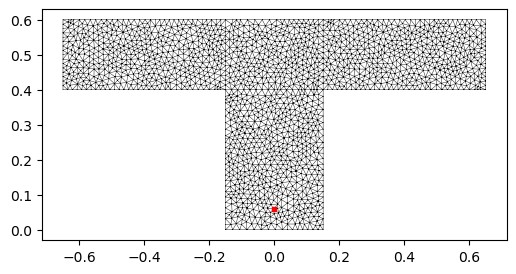

In [23]:
# define sensor locations
sensor_loc = [448]
plot_sensor(mesh, sensor_loc)

# Train Kriging model to predict RB error

In [24]:
# generate input training set
x_Bi1 = np.linspace(0.1, 5.0, 6)
x_Bi2 = np.linspace(0.1, 3.0, 6)
x_q = np.linspace(0.1, 10.0, 10)

mu_train = []
for i in x_Bi1:
    for j in x_Bi2:
        for k in x_q:
            mu_train.append([i, j, k])
mu_train = np.array(mu_train)

# generate output training set -- error between FE and RB models
X = []
Y = []
stime = time.time()
for mu in mu_train:
    # run FE
    reset_cache(truth_problem)
    truth_problem.set_mu(tuple(mu))
    u_fe = truth_problem.solve()
    y_fe = sensor_output(u_fe, sensor_loc)

    # run RB
    reduced_problem.set_mu(tuple(mu))
    u_rb_coeff = reduced_problem.solve()
    u_rb = reduced_problem.basis_functions * u_rb_coeff
    y_rb = sensor_output(u_rb, sensor_loc)

    # compute error
    err = np.linalg.norm(y_fe - y_rb)

    X.append(mu)
    Y.append(err)

X_train = np.array(X) # (N, 3)
Y_train = np.array(Y).reshape(-1,1)  # (N, 1)
etime = time.time()
print('Training data generation time:', etime - stime)

# train Kriging model to preduct RB error
krg_err = Kriging(
    kernel="ardmatern32",
    regularize=True,
    normalize=True,
    n_restart=5
)
stime = time.time()
opt_hyperparas = krg_err.train(X_train, Y_train)
etime = time.time()
print("Kriging model training time:", etime - stime)

Training data generation time: 104.2255756855011


/usr/lib/python3/dist-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Kriging model training time: 117.8042221069336


# Digital twin
We present the following two digital twin scenarios. We assume that sensor output from FE model represents a true sensor ouput from a physical asset. We use trained RB model for inverse identification to cheaply identify the current heat flux and use FE model to monitor the temperature field. If the maximum temperature
1) exceeds a specific threshold, cooling is increased by increasing Biot numbers (this imitates increasing coolant flow rate)
2) falls below a specific threshold, cooling is reduced by reducing Biot numbers.

After control action, we use FE model to display the current temperature field.

## Scenario 1: High device load (Fin overheated)

### Get sensor measurement

In [25]:
mu[0] = 2
mu[1] =1

# set up scenario that q=8
y_true, truth_solution = read_sensor(
    truth_problem=truth_problem,
    mu=mu, q_value=8, sensor_loc=sensor_loc
    )

print("sensor measurement:", y_true)

sensor measurement: [1.50885295]


### Identify current heat flux by solving inverse problem

In [26]:
mu = identify_with_error(reduced_problem, sensor_loc, y_true, mu, kriging=krg_err, initial_guess=1.0)
print("estimated q =", mu[2])

Identification time using error corrected RB model: 0.21787595748901367
estimated q = 7.999988580640661


### Monitor temperature field based on identified heat flux
Identify the current heat flux $q$ by solving least-squares based inverse problem.

system parameters for monitoring: [2.0, 1.0, 7.999988580640661]


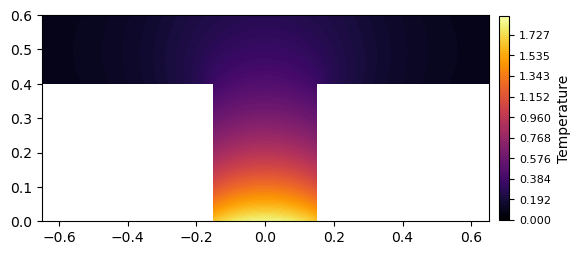

current maximum temperature: 1.8429431073247646


In [27]:
# monitor the tempearture field based on identified q
truth_solution, max_temp = monitor(
    truth_problem=truth_problem,
    mu=mu)

## Control cooling 
If the subfin is determined to be overheated based on the inverse identification, we increase the cooling.

Temperature is too high. Increasing cooling.
system parameters after control: [5, 3, 7.999988580640661]


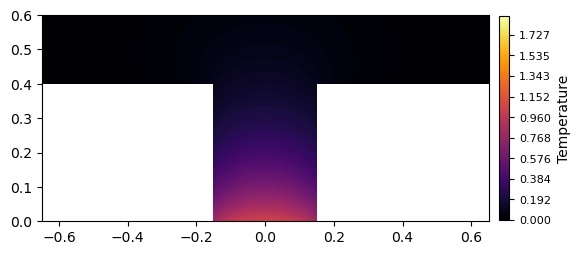

current maximum temperature: 1.043523981274638


In [28]:
mu, truth_solution, max_temp = control_cooling(
    truth_problem=truth_problem,
    current_mu=mu,
    max_temp=max_temp
)

## Scenario 2: Low device load (Fin cooled down)

new measurement: [0.1963927]
Identification time using error corrected RB model: 0.20904803276062012
estimated q = 1.9999281741232673
system parameters for monitoring: [5, 3, 1.9999281741232673]


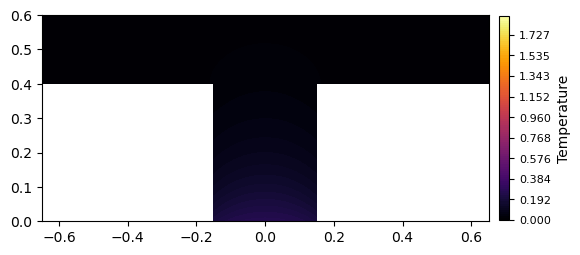

current maximum temperature: 0.2608719986894404
Temperature is already low. Reducing cooling.
system parameters after control: [2, 1, 1.9999281741232673]


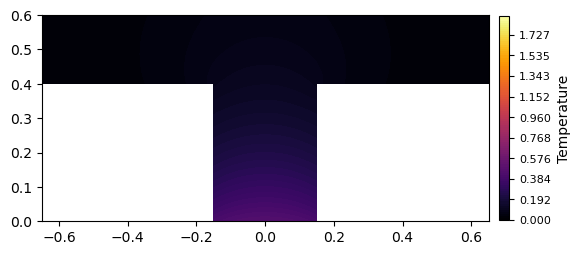

current maximum temperature: 0.4607198880963794


In [29]:
# get updated measurement -- the device load reduced
# set up scenario that q is reduced to 2
y_true, truth_solution = read_sensor(
    truth_problem=truth_problem,
    mu=mu, q_value=2, sensor_loc=sensor_loc
    )
print("new measurement:", y_true)

# identify q
mu = identify_with_error(reduced_problem, sensor_loc, y_true, mu, kriging=krg_err, initial_guess=1.0)
print("estimated q =", mu[2])


# monitor the temperature field based on newly identified q
truth_solution, max_temp = monitor(
    truth_problem=truth_problem,
    mu=mu
    )

# control cooling -- reduce cooling
mu, truth_solution, max_temp = control_cooling(
    truth_problem=truth_problem,
    current_mu=mu,
    max_temp=max_temp
)
